# Ansatz according to Opper

$P(z|x_{t+1}) = \alpha \cdot \sum_{z'}P(z|z')P_t(z') \cdot \int P(x_{t+1}|\theta) P(\theta|x_{1:t}) d\theta$

$P(\theta|x_{t+1}) = \alpha \cdot P(\theta | x_{1:t}) \cdot 
    \left. \Bigg( \sum_{z'}P(z_1|z')P_t(z')  P(x_{t+1} | \theta) +\sum_{z'}P(z_2|z')P_t(z') \int P(\theta_2 | x_{1:t})P(x_{t+1}|\theta_2) \; d\theta_2 \right. \Bigg)$
    


In [1]:
import numpy as np
import math
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import copy
%matplotlib inline 

In [2]:
def TestData(mean=[4,-4], var=[1,1], n=10, skips=2):
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%2],var[i%2],n))
    return data

In [4]:
def evalFilter(f, mean=[5,-5], var=[1,1], n=10, skips=5):
    data = TestData(mean, var, n, skips)
    fA = f
    filterData = []
    z0 = []
    z1 = []
    mean0 = []
    mean1 = []
    var0 = []
    var1 = []
    
    for i,x in enumerate(data[:]):
        filterData.append(fA.update(x))
        z0.append(filterData[-1][0][0])
        z1.append(filterData[-1][0][1])
        mean0.append(filterData[-1][1][0])
        mean1.append(filterData[-1][2][0])
        var0.append(filterData[-1][1][1])
        var1.append(filterData[-1][2][1])
    
    fig, ax1 = plt.subplots()
    ax1.set_ylim([-0.2,1.2])
    t = np.arange(0.01, 10.0, 0.01)
    s1 = np.exp(t)
    ax1.plot(range(0,len(data[:])), z0, 'b')
    ax1.plot(range(0,len(data[:])), z1, 'g')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('probability', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    s2 = np.sin(2 * np.pi * t)
    ax2.plot(range(0,len(data[:])), data[:], 'r.')
    ax2.set_ylabel('data values', color='r')
    ax2.tick_params('y', colors='r')
    plt.title("Probability for the two states at each datum")
    plt.show()

    plt.plot(mean0[:])
    plt.plot(mean1[:])
    plt.scatter(range(0,len(data[:])),data[:], color='red')
    plt.title('mean of the two states')
    plt.show()

    plt.plot(var0)
    plt.plot(var1)
    plt.show

## Most simplified implementation
with $\int P(x_{t+1}|\theta, 1) P(\theta|\mu_{1:t},1) d\theta = \frac{\sqrt{\pi}}{2\pi}\exp(\frac{(x+\mu_{1:t})^2}{4} - \frac{x_{t+1}^2}{2} - \frac{\mu_{1:t}^2}{2})$

and 

$P(\theta|x_{t+1}) = \alpha \cdot P(\theta | x_{1:t}) \cdot 
    \left. \Bigg( \sum_{z'}P(z_1|z')P_t(z')  P(x_{t+1} | \theta) +\sum_{z'}P(z_2|z')P_t(z') \int P(\theta_2 | x_{1:t})P(x_{t+1}|\theta_2) \; d\theta_2 \right. \Bigg)$
    
$P(\theta|x_{t+1}) \approx N(x_{t+1}|\theta,1) \cdot N(\theta|\mu_{1:t}, \sigma_{1:t})$

## And MAP state assosiation

In [3]:
class TwoClassFilter1(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [-1,1.1]
        self.theta1 = [0,1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        
    def computeTheta(self, _x, _theta):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + 1) * (_x + theta[0]/theta[1])
        return theta
    
    def computeIntegral(self, _x, _theta): # it assumes the wrong var for now
        exp = np.exp( (_x + _theta[0])**2/4.0 - (_x**2-_theta[0]**2)/2 )
        return np.sqrt(np.pi)/(2*np.pi) * exp
    
    def update(self, _x): 
        #compute probability of x beeing from z[0] or z[1]
        #i.e. the likelihood of _x beeing from z
        #which is P(x|theta) = norm(x|theta[mean], 1)
        #likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        #likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        w0 = 1#self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1]
        w1 = 1#self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1]
        
        integral0 = self.computeIntegral(_x, self.theta0)
        integral1 = self.computeIntegral(_x, self.theta1)
        
        z0 = w0 * integral0
        z1 = w1 * integral1
        
        self.z[0] = z0/(z0+z1)
        self.z[1] = z1/(z0+z1)
        
        if(self.z[0]>self.z[1]):
            self.theta0 = self.computeTheta(_x, self.theta0)
        else:
            self.theta1 = self.computeTheta(_x, self.theta1)
        
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]
        return self.z, self.theta0, self.theta1

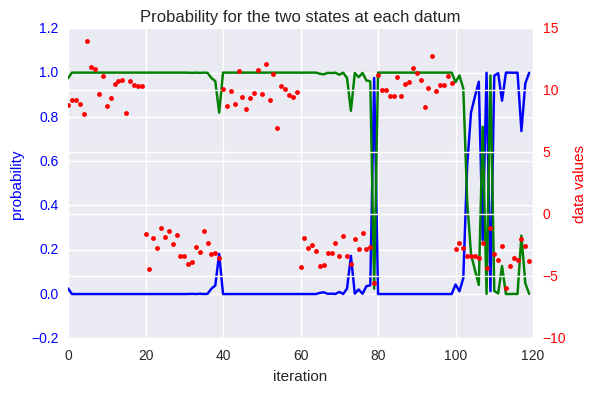

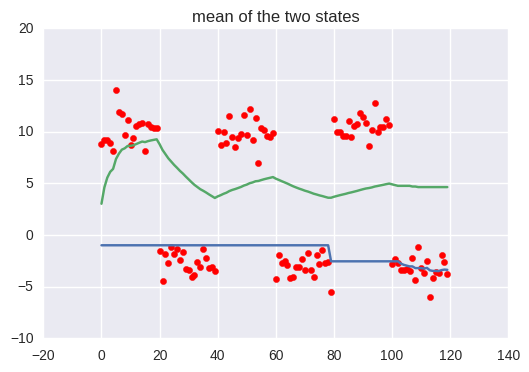

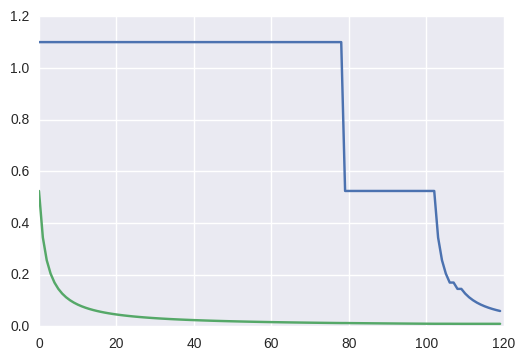

In [5]:
evalFilter(TwoClassFilter1(), mean=[-3,10], n =20)

## Filter with more complex Integral

In [6]:
class TwoClassFilter2(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [-2,1.1]
        self.theta1 = [2,1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        
    def computeTheta(self, _x, _theta):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + 1) * (_x + theta[0]/theta[1])
        return theta
    
    def computeIntegral(self, _x, _theta):
        a = (_x**2 / (1 + (1 / _theta[1]))) + (( (_theta[0]**2 / _theta[1])) / (1 + (1 / _theta[1])))
        b = (_x + (_theta[0]/_theta[1]))/(1 + (1 / _theta[1]))
        exp = np.exp(-1/(2 +( 1/(1 + (1 / _theta[1])))) * (a - b**2))
        return np.sqrt(2*np.pi * 1/(1 + 1/_theta[1]))/(np.sqrt(2*np.pi) * np.sqrt(2*np.pi *_theta[1])) * exp
    
    def update(self, _x): 
        #compute probability of x beeing from z[0] or z[1]
        #i.e. the likelihood of _x beeing from z
        #which is P(x|theta) = norm(x|theta[mean], 1)
        likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        w0 = self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1]
        w1 = self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1]
        
        integral0 = self.computeIntegral(_x, self.theta0)
        integral1 = self.computeIntegral(_x, self.theta1)
        z0 = w0 * integral0
        z1 = w1 * integral1
        
        self.z[0] = z0/(z0+z1)
        self.z[1] = z1/(z0+z1)
        
        if(self.z[0]>self.z[1]):
            self.theta0 = self.computeTheta(_x, self.theta0)
        else:
            self.theta1 = self.computeTheta(_x, self.theta1)
        
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]
        return self.z, self.theta0, self.theta1

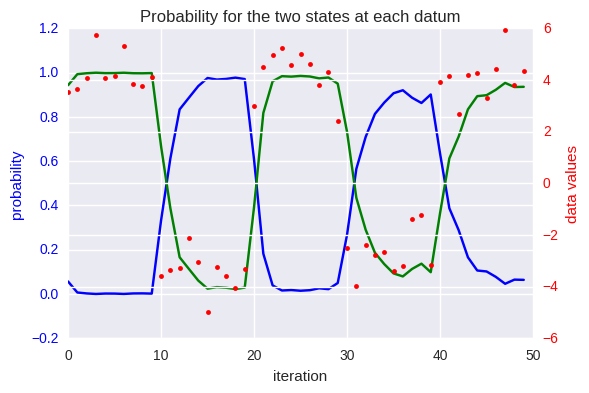

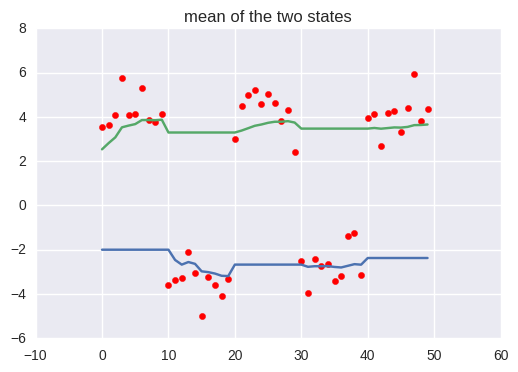

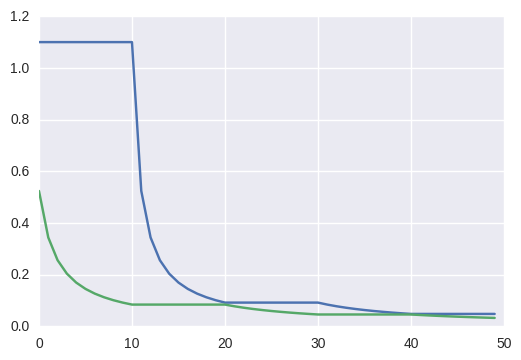

In [23]:
evalFilter(TwoClassFilter2(), mean=[-3,4], n = 10, skips =4)

## FIlter with more complex integral in log-space

In [4]:
class TwoClassFilter4(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [-2,1.1]
        self.theta1 = [2,1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        
    def computeTheta(self, _x, _theta):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + 1) * (_x + theta[0]/theta[1])
        return theta
    
    def computeIntegral(self, _x, _theta): 
        a = (_x**2 / (1 + (1 / _theta[1]))) + ((_theta[0]**2 / _theta[1]) / (1 + (1 / _theta[1])))
        b = (_x + (_theta[0]/_theta[1]))/(1 + (1 / _theta[1]))
        c = -1/(2 +( 1/(1 + (1 / _theta[1])))) * (a - b**2)
        ln = 0.5 * (np.log(1) - np.log(1 + 1/_theta[1]) - np.log(2* np.pi) - np.log(_theta[1]))
        return ln * c
    
    def update(self, _x): 
        #compute probability of x beeing from z[0] or z[1]
        #i.e. the likelihood of _x beeing from z
        #which is P(x|theta) = norm(x|theta[mean], 1)
        likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        w0 = self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1]
        w1 = self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1]
        
        integral0 = self.computeIntegral(_x, self.theta0)
        integral1 = self.computeIntegral(_x, self.theta1)
        z0 = w0 * integral0
        z1 = w1 * integral1
        
        self.z[0] = z0/(z0+z1)
        self.z[1] = z1/(z0+z1)
        
        if(self.z[0]>self.z[1]):
            self.theta0 = self.computeTheta(_x, self.theta0)
        else:
            self.theta1 = self.computeTheta(_x, self.theta1)
        
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]
        return self.z, self.theta0, self.theta1

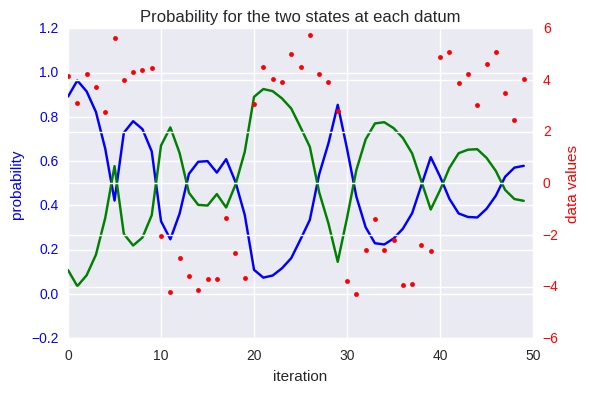

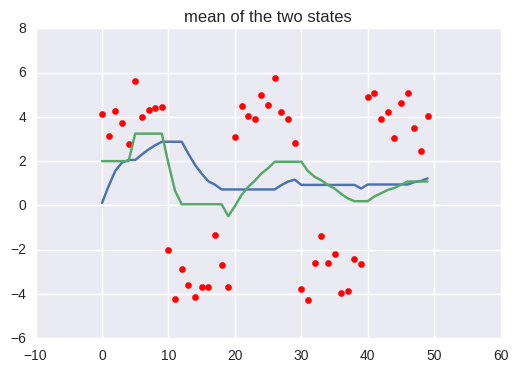

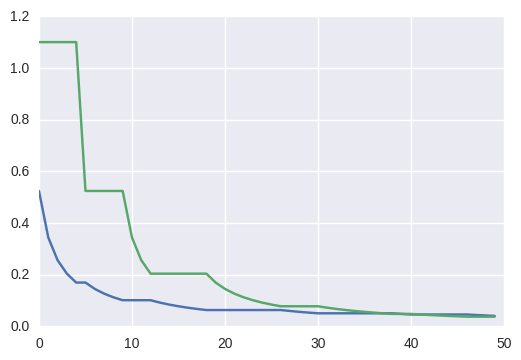

In [5]:
evalFilter(TwoClassFilter4(), mean=[-3,4], n = 10, skips =4)

## Filter with Bayes Assigment of state probability 

In [18]:
class TwoClassFilter3(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [-4,1.1]
        self.theta1 = [2,1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        
    def computeTheta(self, _x, _theta, _z):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + _z) * ((_z*_x) + theta[0]/theta[1])
        return theta
    
    def computeIntegral(self, _x, _theta): # it assumes the wrong var for now
        exp = np.exp( (_x + _theta[0])**2/4 - (_x**2-_theta[0]**2)/2 )
        return np.sqrt(np.pi)/(2*np.pi) * exp
    
    def update(self, _x): 
        #compute probability of x beeing from z[0] or z[1]
        #i.e. the likelihood of _x beeing from z
        #which is P(x|theta) = norm(x|theta[mean], 1)
        likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        w0 = self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1]
        w1 = self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1]
        
        integral0 = self.computeIntegral(_x, self.theta0)
        integral1 = self.computeIntegral(_x, self.theta1)
        
        z0 = w0 * integral0
        z1 = w1 * integral1
        
        self.z[0] = z0/(z0+z1)
        self.z[1] = z1/(z0+z1)
        
        
        self.theta0 = self.computeTheta(_x, self.theta0, self.z[0])
        self.theta1 = self.computeTheta(_x, self.theta1, self.z[1])
        
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]
        return self.z, self.theta0, self.theta1

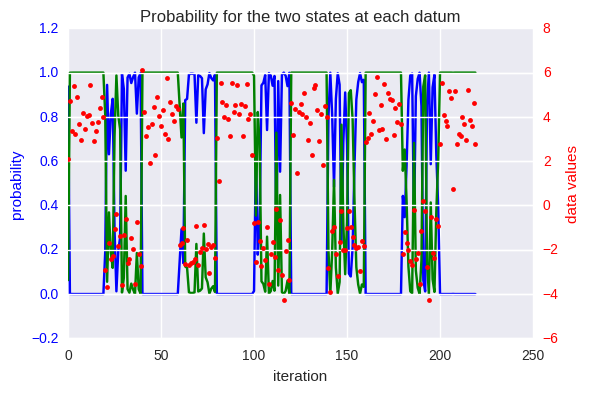

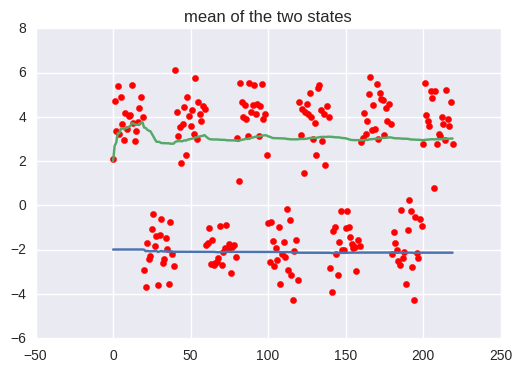

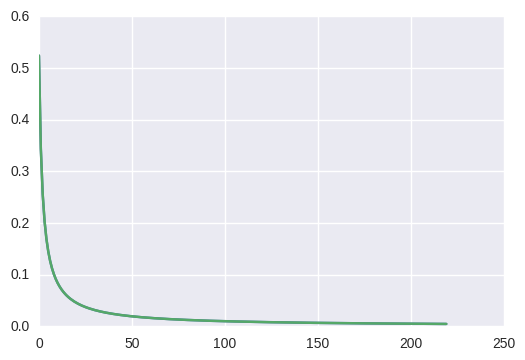

In [21]:
evalFilter(TwoClassFilter3(), mean=[-2,4], n = 20, skips =10)

# New Implementation from 13.3

In [51]:
class TwoClassFilter4(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [-4,1.1]
        self.theta1 = [2,1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        
        self.thetaProb = [0.5,0.5]
        
    def computeTheta(self, _x, _theta, _likelihood):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + _likelihood) * ((_likelihood*_x) + theta[0]/theta[1])
        return theta
    
    def computeIntegralSimple(self, _x, _theta): # it assumes the wrong var for now
        exp = np.exp( (_x + _theta[0])**2/4 - (_x**2-_theta[0]**2)/2 )
        return np.sqrt(np.pi)/(2*np.pi) * exp
    
    def computeIntegral(self, _x, _theta): 
        a = (_x**2 / (1 + (1 / _theta[1]))) + ((_theta[0]**2 / _theta[1]) / (1 + (1 / _theta[1])))
        b = (_x + (_theta[0]/_theta[1]))/(1 + (1 / _theta[1]))
        c = -1/(2 +( 1/(1 + (1 / _theta[1])))) * (a - b**2)
        ln = 0.5 * (np.log(1) - np.log(1 + 1/_theta[1]) - np.log(2* np.pi) - np.log(_theta[1]))
        return ln * c
    
    def update(self, _x):         
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        w0 = self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1]
        w1 = self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1]
        
        integral0 = self.computeIntegral(_x, self.theta0)
        integral1 = self.computeIntegral(_x, self.theta1)
        
        likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        
        self.thetaProb = [1,1]
        
        thetaProb0 = (likelihood0 * self.thetaProb[0] * w0) + (self.thetaProb[0] * w1 * integral1)
        thetaProb1 = (likelihood1 * self.thetaProb[1] * w1) + (self.thetaProb[1] * w0 * integral0)
        print 'theta prob unorm', thetaProb0, thetaProb1
        self.thetaProb[0] = thetaProb0/(thetaProb0+thetaProb1)
        self.thetaProb[1] = thetaProb1/(thetaProb0+thetaProb1)
        
        self.theta0 = self.computeTheta(_x, self.theta0, self.thetaProb[0])
        self.theta1 = self.computeTheta(_x, self.theta1, self.thetaProb[1])
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]
        #print _x
        #print 'likelihoods',likelihood0,likelihood1
        #print 'theta prob', self.thetaProb
        #print 'theta', self.theta0, self.theta1
        #print '=========='
        
        
        
        z0 = w0 * integral0
        z1 = w1 * integral1
        
        self.z[0] = z0/(z0+z1)
        self.z[1] = z1/(z0+z1)
        
        return self.z, self.theta0, self.theta1

theta prob unorm 0.355772780284 4.46982272134
theta prob unorm 0.0421735050852 5.90200700663
theta prob unorm 0.000107735207958 3.92494427444
theta prob unorm 0.00439408496917 4.0030910962
theta prob unorm 0.174218198661 0.304286374253
theta prob unorm 0.286959885009 0.272382066481
theta prob unorm 1.06415085387 0.000772054224841
theta prob unorm 1.68398998721 0.000571207142998
theta prob unorm 0.0369284668009 0.424725466789
theta prob unorm 0.00334028108852 1.39080011518
theta prob unorm 0.00215739552491 1.51990004545
theta prob unorm 0.0111715805311 1.88184892637
theta prob unorm 0.236020162576 0.0454724324452
theta prob unorm 0.6076196449 0.00739756618981
theta prob unorm 0.559741580511 0.00534867477452
theta prob unorm 0.350739384925 0.0123189100408
theta prob unorm 0.179243101616 0.242555381387
theta prob unorm 0.0197906303957 0.721212639369
theta prob unorm 0.000591565321694 0.802330006768
theta prob unorm 0.00233672721009 0.916304664364
theta prob unorm 0.414121567974 0.00250581

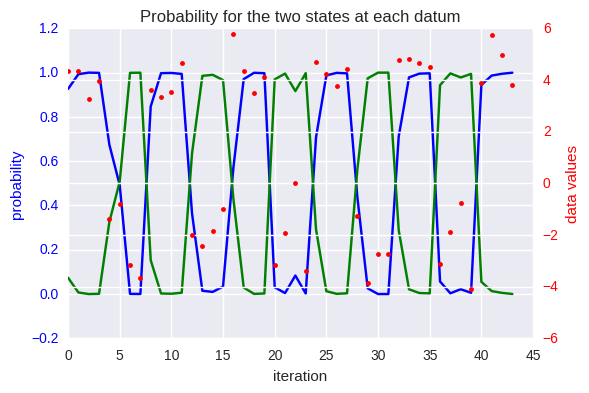

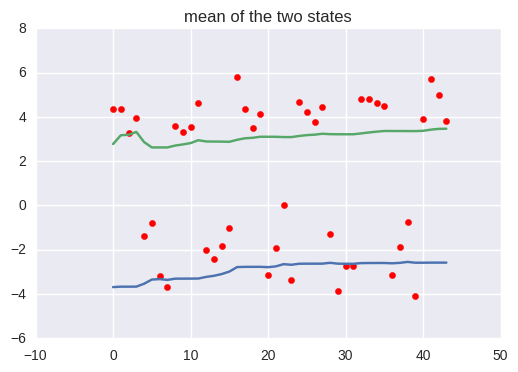

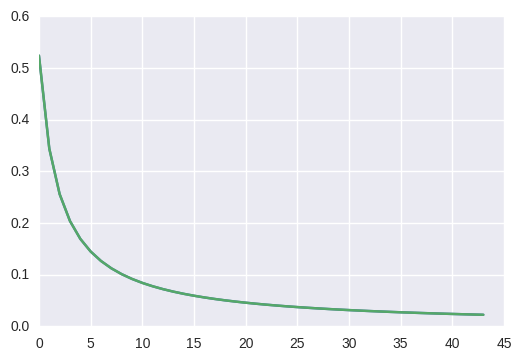

In [52]:
evalFilter(TwoClassFilter4(), mean=[-2,4], n = 4, skips =10)